# Natural Algorithms Genetic algorithm


In [1]:
import pandas as pd
import numpy as np
import random
import csv

# 1 Fitness function

In [2]:
def getFitness(population):
    fitnessofpopulation = []
    runtimeofeverymachineinachromosome = []
    for machine in range(machinecount):
        runtimeofeverymachineinachromosome.append(0)
    for state in population:
        for machine in range(machinecount):
            runtimeofeverymachineinachromosome[machine] = 0
        for job in range(len(state)-1):
            runtimeofeverymachineinachromosome[state[job]] -= int(values[job][0])
        fitnessofpopulation.append(min(runtimeofeverymachineinachromosome))  
    correction = min(fitnessofpopulation)-1
    index = 0
    for fitness in fitnessofpopulation:
        fitnessofpopulation[index] = fitness - correction
        index+=1
    return fitnessofpopulation

In [3]:
def getBestRuntime(population):
    fitnessofpopulation = []
    runtimeofeverymachineinachromosome = []
    for machine in range(machinecount):
        runtimeofeverymachineinachromosome.append(0)
    for state in population:
        for machine in range(machinecount):
            runtimeofeverymachineinachromosome[machine] = 0
        for job in range(len(state)-1):
            runtimeofeverymachineinachromosome[state[job]] += int(values[job][0])
        fitnessofpopulation.append(max(runtimeofeverymachineinachromosome))
    return min(fitnessofpopulation)

# 2 Initializer

In [4]:
# This method calls the random or heuristic initializer

def initialize(init_method):
    if init_method == "random":
        pop = initialize_random()
    elif init_method == "heuristic":
        pop = initialize_heuristic()

    return pop

In [5]:
# This method initializes a population with random chromosomes

def initialize_random():
    pop = []
    for chromosome in range(popsize):
        # initialize empty list which represents the chromosome
        jobs = []
        # assign a random machine to each job    
        for job in range(jobcount):
            jobs.append(random.randint(0,machinecount-1))
    
        pop.append(jobs)
    return pop

## 2.1 Intialize heuristic

In [6]:
# This method initializes a population with heuristic chromosomes
# For every chromosome: We use the ratio between jobs/machines to assign every machine to a nearly identical number of jobs.
# If we assume that all jobs need the same processing time, this would already yield a nearly perfect solution.

def initialize_heuristic():
    pop = []

    for chromosome in range(popsize):
        jobs = []
        machines = []
        not_heuristic = True

        #create list that serves to count how many jobs a machine is assigned to
        for machine in range(machinecount):
            machines.append(0)
    
        ratio = int(jobcount/machinecount)

        #assign a random machine to each job and count how often each machine is assigned
        for job in range(jobcount):
            machine = random.randint(0,machinecount-1)
            jobs.append(machine)
            machines[machine] += 1

        #change the machine assignment such that every machine is assigned a nearly identical number of jobs
        while not_heuristic:
            #i is used to count machines that dont have enough jobs assigned to them, given by the ratio
            i = 0
            #used as machine index
            machine = 0
    
            #check for every machine
            for counter in machines:
                #if it has enough jobs assigned, given by the ratio
                if counter < ratio:
                    #if it doesnt, we assign it to one more random job 
                    jobs[random.randint(0,jobcount-1)] = machine
                    i += 1     
                machine += 1
        
            #empty the counter list    
            machines.clear()
            for machine in range(machinecount):
                machines.append(0)
    
            #count again how often each machine is assigned 
            for job in jobs:
                machines[job] += 1
    
            #stop if there are no more machines that dont have enough jobs
            if i == 0:    
                not_heuristic = False 
    
        pop.append(jobs)

    return pop     

# 3 Selection

In [31]:
def select(sel_method, population):
    matingPool = []
    if(sel_method == "fitness_proportionate"):
        #print("Hello")
        #run = 0
        #while run in range(matingsize):
        matingPool = fitness_proportionate(population)
        #print(matingPool)
    elif(sel_method == "truncated"):
        #print("Hello1")
        matingPool = truncated(population, int(popsize*0.25))
    elif(sel_method == "tournament"):
        #print("Hello2")
        #run = 0
        #while run in range(matingsize):
        matingPool = tournament(population, int(popsize*0.3))
        #if selected not in matingPool:
         #   matingPool.append(selected)
         #   run+=1
    return matingPool

In [8]:
def fitness_proportionate(population):
    probabilityList = []
    matingPool = []
    fitnessList = getFitness(population)
    comulatedFit = sum(fitnessList)
    for fitness in fitnessList:
        probabilityList.append((fitness/comulatedFit))
    for run in range(matingsize):
        #print(range(matingsize))
        index = int(np.random.choice(popsize, 1, probabilityList))
        fitnessList[index] = 0
        comulatedFit = sum(fitnessList)
        probabilityList = []
        for fitness in fitnessList:
            if(comulatedFit != 0):
                probabilityList.append((fitness/comulatedFit))
            else:
                break
        #print(population[index])
        matingPool.append(population[index])
        #print(matingPool)    
        comulatedProb = sum(probabilityList)
        #print(comulatedProb)
    return matingPool

In [9]:
def truncated(population, s):
    fitnessList = getFitness(population)
    matingPool = []
    for run in range(int(popsize/s)):
        fittest = fitnessList.index(max(fitnessList))
        for i in range(s):
            matingPool.append(population[fittest])
        fitnessList[fittest] = 0
        
    return matingPool
        
        

In [10]:
def tournament(population, s):
    fittestChosen = []
    for run in range(matingsize):
        chosenStates = []
        chosenNum = np.random.choice(popsize, s)
        for num in chosenNum:
            chosenStates.append(population[num])
        fittest = getFitness(chosenStates).index(max(getFitness(chosenStates)))
        fittestChosen.append(chosenStates[fittest])
    return fittestChosen

# 4 Recombination Algorithms

In [11]:
def recombine(rec_method, mating_pool):
    """Calls wanted recombine method"""
    if rec_method == 'k-point_crossover':
        offspring = kpoint(mating_pool)
        
    if rec_method == 'uniform_crossover':
        offspring = uniformorderbased(mating_pool)
        
    return offspring

## 4.1 k-point crossover

In [12]:
# k-point crossover

def kpoint(population):
    
    # generating k
    k = random.randint(1, len(population[0])-1)
    
    # generating crossover
    crossover = []
    for i in range(k):
        crossover.append(random.randint(1, len(population[0])-1))

    # Generating childs aka new population
    result = []
    switch = True
    for parent in range(1, len(population), 2):
        counter = 0
        child1 = []
        child2 = []
        for elementp1, elementp2 in zip(population[parent - 1], population[parent]):
            if switch:
                child1.append(elementp1)
                child2.append(elementp2)
            else:
                child1.append(elementp2)
                child2.append(elementp1)
            counter += 1
            if counter in crossover:
                switch^=True
        result.append(child1)
        result.append(child2)
    
    return result

## 4.2 Uniform order based crossover

In [13]:
def uniformorderbased(population):
    
    # Generating Template
    template = []
    for i in range(len(population[0])):
        template.append(random.randint(0, 1))

    # Generating children aka new population
    result = []
    for parent in range(1, len(population), 2):
        counter = 0
        child1 = []
        child2 = []
        for elementp1, elementp2 in zip(population[parent - 1], population[parent]):
            if template[counter] == 1:
                child1.append(elementp1)
                child2.append(elementp2)
            else:
                child1.append(elementp2)
                child2.append(elementp1)
            counter += 1

        result.append(child1)
        result.append(child2)
    return result

# 5 Mutation

In [14]:
def mutate(mut_method, offspring):
    if mut_method == "bitflip":
        offspring = bitflip(offspring)
    if mut_method == "swap":
        offspring = swap(offspring)
        
    return offspring

In [15]:
def bitflip(offspring):
    state = offspring[random.randint(0, len(offspring)-1)]
    index = offspring.index(state)

    i = 0
    while i < len(state):
        state[i] = random.randint(0, machinecount - 1)
        i += 1
        
    offspring[index] = state    
    
    return offspring

In [16]:
def swap(offspring):
    state = offspring[random.randint(0, len(offspring)-1)]
    index = offspring.index(state)

    i = 0
    m = random.randInt(1, len(state)-1)
    while i < m:
        index1 = random.randint(0, len(state)-1)
        value1 = state[index1]
        index2 = random.randint(0, len(state)-1)
        value2 = state[index2]
        state[index1] = value2
        state[index2] = value1
        i += 1
        
    offspring[index] = state
    
    return offspring

# 6 Replacement

In [17]:
def replace(rep_method, population, offspring):
    if rep_method == "steady_state":
        pop = steady_state(population, offspring)
    elif rep_method == "dellAll":
        pop = dellAll(population, offspring)
    elif rep_method == "elitist":
        pop = elitist(population, offspring)
        
    return pop    

In [18]:
def runtimecounter(dataList,machineCount,population):
    subCount = 0
    for i in range(0,len(population)):
        # range(0,machinecount+1)
        for j in range(1,10):
            count = 0
            for x in range(0,len(dataList)):
                if j == population[i][x]:
                    count = count + dataList[x]
            if count > subCount:
                subCount = count
                identification = i
                
    return identification

In [19]:
# delete the worst chromosome
def steadyState(population, offspring):
    population.extend(offspring)
    return population.remove(runtimecounter(dataList,machineCount,population))

In [20]:
def dellAll(population, offspring):
    return offspring

In [21]:
def elitist(population, offspring):
    newPopulation = []
    population.extend(offspring)
    fitnessList = getFitness(population)
    for i in range(popsize):
        fittest = fitnessList.index(max(fitnessList))
        newPopulation.append(population[fittest])
        fitnessList[fittest] = 0
    return newPopulation

In [22]:
def steady_state(population, offspring):
    fitnessList = getFitness(population)
    for i in range(int((len(offspring)-1))):
        fittest = fitnessList.index(min(fitnessList))
        population.remove(population[fittest])
        fitnessList.remove(fitnessList[fittest])
    population.extend(offspring)
    return population

# 7 Main

## 7.1 Eingabe

In [39]:
eingabe = input("Welche benchmark soll laufen? ")
casesPop = [10, 50, 100, 200]

popsize = 0
matingsize = 0


with open(eingabe + ".csv") as f:
    reader = csv.reader(f)
    next(reader) # skip header
    values = []
    for row in reader:
        values.append(row)

eingabe = eingabe.split("_")

machinecount = int(eingabe[1])
jobcount = int(eingabe[2])

Welche benchmark soll laufen? benchmark3_50_100


## 7.2 Pseudocode

In [40]:
def main(initializer, selector, recombiner, mutator, replacer):
    population = initialize(initializer)
    bestRuntime = getBestRuntime(population)
    counter = 0
    #print(replacer)
    while (counter<50):
        mating_pool = select(selector, population)
        #print(len(mating_pool))
        #print(mating_pool)
        offspring = recombine(recombiner, mating_pool)
        #print(len(offspring))
        if(np.random.choice(1, 1, [0.5, 0.5])==1):
            offspring = mutate(mutator, offspring)
        #print(len(offspring))
        population = replace(replacer, population, offspring)
        #print(len(population))
        currentBest = getBestRuntime(population)
        if(currentBest < bestRuntime):
            bestRuntime = currentBest
            counter = 0
        else:
            counter+=1
        #print(bestRuntime)
    return getBestRuntime(population)

proc_times = []
nested = []
for i in casesPop:
    popsize = i
    casesMate = [int(i*0.2), int(i*0.8)]
    for j in casesMate:
        matingsize = j
        for a in range(10):
            proc_times.append(main())
            print(a)
        nested.append(proc_times)
        proc_times= []
            

print(proc_times)

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot(nested)

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['p 10, m 0.2', 'p 10, m 0.8', 'p 50, m 0,2', 'p 50, m 0,8', 'p 100, m 0.2', 'p 100, m 0.8', 'p 200, m 0.2', 'p 200, m 0.8'],
          rotation=25, ha='right')
ax.set_ylabel("Max Runtime")
plt.show()


In [26]:
#print(nested)

In [27]:
# [[7765, 7192, 7711, 7030, 7188, 7440, 6965, 7365, 7647, 7537], [7280, 6922, 7148, 7140, 6769, 7141, 7254, 7416, 7465, 7450], [7049, 7276, 7429, 6816, 7264, 6532, 7200, 7163, 7261, 6443], [6965, 6653, 6642, 6490, 7092, 7170, 6432, 6593, 6691, 6557], [7335, 7165, 7336, 7154, 7412, 7304, 6993, 6984, 7187, 7182], [6877, 6433, 7144, 6684, 6354, 6509, 6433, 6512, 6562, 6460], [7329, 7152, 6915, 7109, 7214, 7094, 7357, 7357, 7237, 7313], [7123, 6595, 6969, 7132, 6452, 6934, 6692, 6728, 6777, 7023]]

In [41]:
proc_times = []
nested = []
popsize = 50
matingsize = int(popsize*0.8)
mode = []
modulu = []

for initializer in ['random', 'heuristic']:
    for selector in ['tournament', 'fitness_proportionate']:
        for recombiner in ['k-point_crossover', 'uniform_crossover']:
            for mutator in ['bitflip', 'swap']:
                for replacer in ['steady_state', 'elitist']:
                    for a in range(10):
                        proc_times.append(main(initializer, selector, recombiner, mutator, replacer))
                        print(a)
                    nested.append(proc_times)
                    mode = [initializer, selector, recombiner, mutator, replacer]
                    print(mode)
                    modulu.append(mode)
                    print(proc_times)
                    proc_times= []

0
1
2
3
4
5
6
7
8
9
['random', 'tournament', 'k-point_crossover', 'bitflip', 'steady_state']
[298, 308, 272, 319, 320, 295, 270, 297, 265, 315]
0
1
2
3
4
5
6
7
8
9
['random', 'tournament', 'k-point_crossover', 'bitflip', 'elitist']
[292, 259, 314, 312, 326, 312, 309, 320, 310, 316]
0
1
2
3
4
5
6
7
8
9
['random', 'tournament', 'k-point_crossover', 'swap', 'steady_state']
[304, 305, 290, 297, 302, 302, 303, 323, 317, 326]
0
1
2


KeyboardInterrupt: 

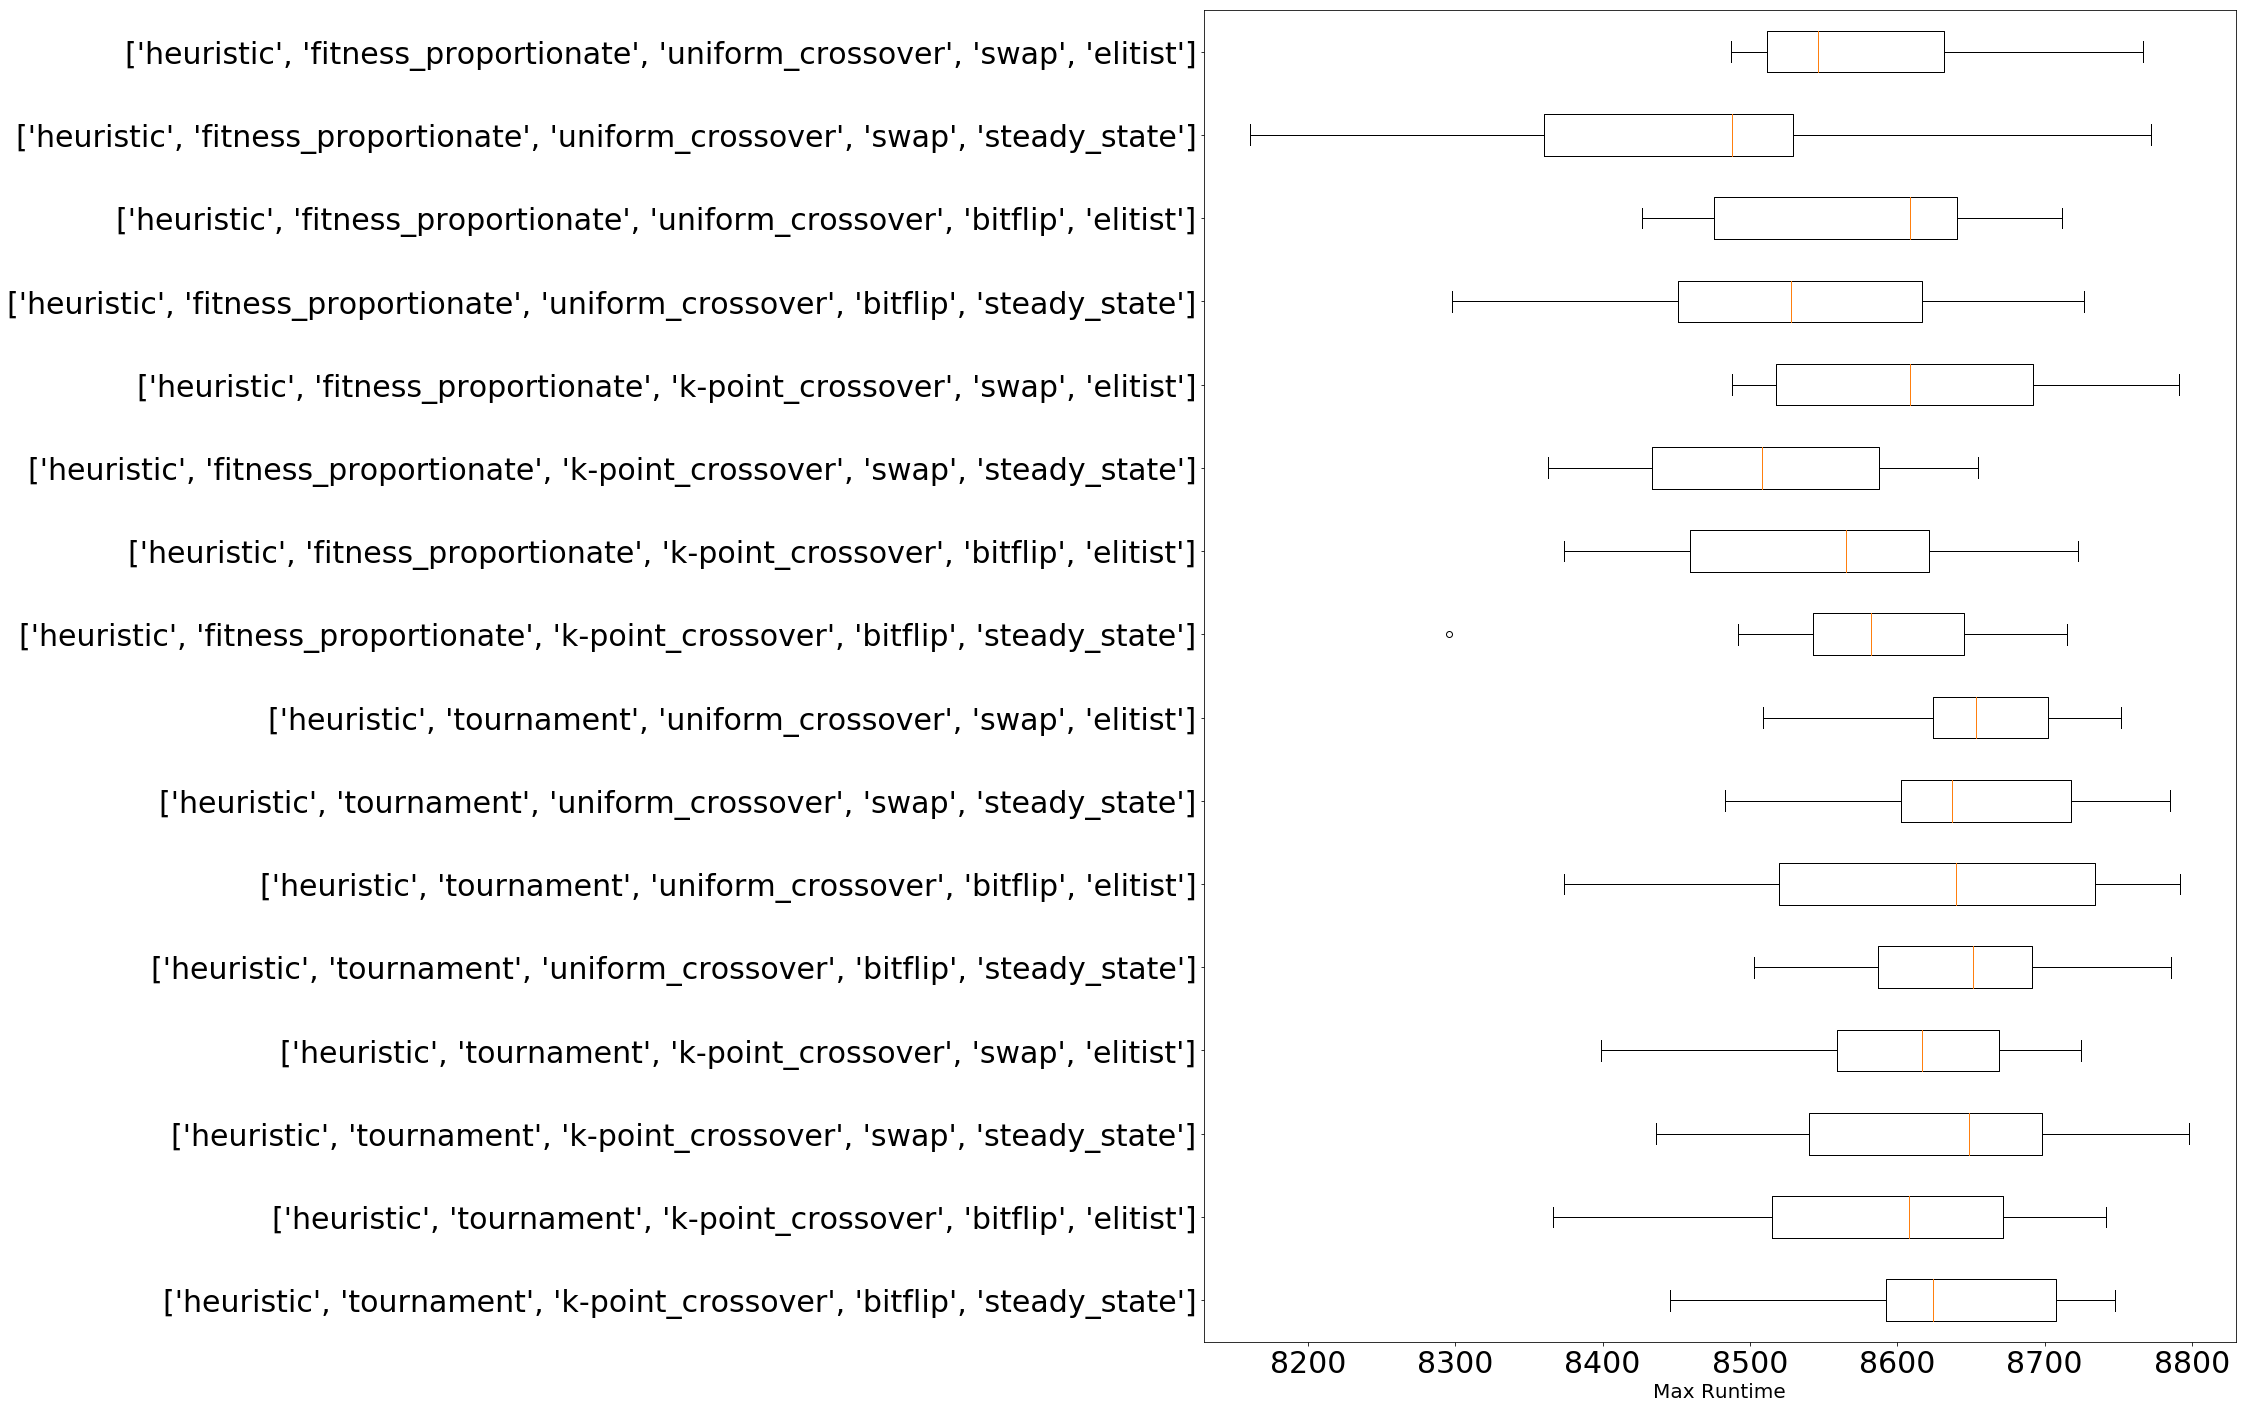

In [38]:
von = 17
bis = 32
data = nested
labels = modulu

fig, ax = plt.subplots()
ax.boxplot(data[von-1:bis], vert=False)
plt.yticks(range(1, bis-von +2), labels[von-1 :bis], size=20)
ax.tick_params(labelsize= 30)
fig.set_size_inches(18.5, 24.5)
ax.set_xlabel("Max Runtime",size=20)

plt.show()